---
**License**

 Rosenbrock

 Thu Feb 07 16:49:00 2023\
 Copyright  2023\
 Sandro Dias Pinto Vitenti  <vitenti@uel.br>

---
---

 Rosenbrock\
 Copyright (C) 2023 Sandro Dias Pinto Vitenti  <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
# For NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import math

from getdist import plots, MCSamples
import getdist
from getdist.styles.tab10 import style_name
plots.set_active_style(style_name)

import sys
sys.path.insert(0,'../../scripts')

from plot_tools import confidence_ellipse
from plot_tools import set_rc_params_article
from nc_getdist import mcat_to_mcsamples


In [2]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

set_rc_params_article(ncol=1)

In [3]:
nwalkers = 320
burnin   = 5000

mcat_apes = Ncm.MSetCatalog.new_from_file_ro("../../examples/example_rosenbrock_apes_st_320.fits", nwalkers * burnin)
mcat_stretch = Ncm.MSetCatalog.new_from_file_ro("../../examples/example_rosenbrock_stretch_st_320.fits", nwalkers * burnin)

assert mcat_apes.nchains() == nwalkers
assert mcat_apes.nchains() == mcat_stretch.nchains()

In [4]:
mcat_apes.estimate_autocorrelation_tau(False)
print (mcat_apes.peek_autocorrelation_tau().dup_array())
print (mcat_apes.get_shrink_factor())

mcat_stretch.estimate_autocorrelation_tau(False)
print (mcat_stretch.peek_autocorrelation_tau().dup_array())
print (mcat_stretch.get_shrink_factor())

[5.7417223011045975, 5.529719419837306, 10.589808009649243]
1.0004985547850154
[69.36281061118697, 1754.1740395579347, 1775.7339316483433]
1.2000265618645993


In [5]:
sample_apes, rows_apes, posterior_apes = mcat_to_mcsamples(mcat_apes, "APES")
del mcat_apes

sample_stretch, rows_stretch, posterior_stretch = mcat_to_mcsamples(mcat_stretch, "STRETCH")
del mcat_stretch

Removed no burn in
Removed no burn in


In [6]:
print(sample_apes.getConvergeTests(what=('MeanVar', 'GelmanRubin', 'SplitTest', 'CorrLengths'), feedback=True))
print(sample_stretch.getConvergeTests(what=('MeanVar', 'GelmanRubin', 'SplitTest', 'CorrLengths'), feedback=True))

Number of chains used =  320
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00109
Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
x_1              4.29E+00            4.29          793331
x_2              7.83E+00            7.83          434148


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

x_1           0.0234  x_1
x_2           0.0307  x_2

var(mean)/mean(var) for eigenvalues of covariance of y of orthonormalized parameters
  1      0.00054
  2      0.00109

Split tests: rms_n([delta(upper/lower quantile)]/sd) n={2,3,4}, limit=95%:
i.e. mean sample splitting change in the quantiles in units of the st. dev.

x_1          0.0010   0.0047   0.0096 upper
x_1          0.0030   0.0063   0.0050 lower
x_2          0.0035   0.0067   0.0153 upper
x_2          0.0000   0.0001   0.0001 lower


Number of chains used =  320

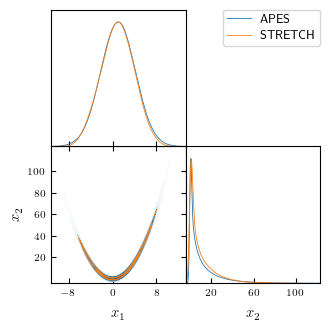

In [7]:
g = plots.get_subplot_plotter(width_inch=plt.rcParams['figure.figsize'][0])
g.triangle_plot([sample_apes, sample_stretch], shaded=True)


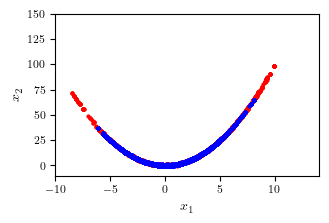

In [8]:
fig, ax = plt.subplots()
ax.set(xlim=(-10, 14), ylim=(-10, 150))
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

scat_apes = ax.scatter(rows_apes[0:nwalkers,0], rows_apes[0:nwalkers,1], s = 4, c = "red")
scat_stretch = ax.scatter(rows_stretch[0:nwalkers,0], rows_stretch[0:nwalkers,1], s = 4, c = "blue")

nframes = 600
b = np.unique (np.floor (np.linspace (0, rows_apes.shape[0] / nwalkers, nframes)).astype(int))
nframes = len (b)

def animate(i):
    x_i = rows_apes[nwalkers * b[i] : nwalkers * b[i + 1], 0]
    y_i = rows_apes[nwalkers * b[i] : nwalkers * b[i + 1], 1]
    x2_i = rows_stretch[nwalkers * b[i] : nwalkers * b[i + 1], 0]
    y2_i = rows_stretch[nwalkers * b[i] : nwalkers * b[i + 1], 1]
    scat_apes.set_offsets(np.c_[x_i, y_i])
    scat_stretch.set_offsets(np.c_[x2_i, y2_i])

anim = FuncAnimation (fig, animate, interval=50, frames=nframes-1)
pass

In [9]:
HTML(anim.to_jshtml())

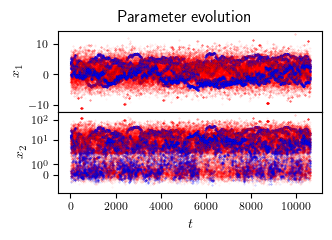

In [10]:
fig = plt.figure()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle('Parameter evolution')

step = 1
t = np.arange(len(rows_apes) / nwalkers, step = step)

for i in range(0, nwalkers, 50):
    x_1_apes = rows_apes[i::nwalkers,0]
    x_1_stretch = rows_stretch[i::nwalkers,0]
    x_2_apes = rows_apes[i::nwalkers,1]
    x_2_stretch = rows_stretch[i::nwalkers,1]
    
    axs[0].scatter(t, x_1_apes[::step], s=0.1, alpha=0.1, color="r")
    axs[0].scatter(t, x_1_stretch[::step], s=0.1, alpha=0.1, color="b")

    axs[1].scatter(t, x_2_apes[::step], s=0.1, alpha=0.1, color="r")
    axs[1].scatter(t, x_2_stretch[::step], s=0.1, alpha=0.1, color="b")
    
axs[1].set_yscale("symlog")

axs[0].set_ylabel("$x_1$")
axs[1].set_ylabel("$x_2$")
axs[1].set_xlabel("$t$")

pass

In [ ]:
kernel = Ncm.StatsDistKernelST.new (2, 1.0)
interp_apes = Ncm.StatsDistVKDE.new (kernel, Ncm.StatsDistCV.NONE)
interp_stretch = Ncm.StatsDistKDE.new (kernel, Ncm.StatsDistCV.NONE)

interp_apes.set_cov_type (Ncm.StatsDistKDECovType.ROBUST)
interp_stretch.set_cov_type (Ncm.StatsDistKDECovType.ROBUST)

In [ ]:
max_n = len(rows_apes)
ssize = int(nwalkers/2)

interp_apes.reset()
interp_stretch.reset()

for theta_apes, theta_stretch in zip (rows_apes[-ssize:], rows_stretch[-ssize:]):
    theta_apes_v = Ncm.Vector.new_array (theta_apes)
    interp_apes.add_obs (theta_apes_v)
    
    theta_stretch_v = Ncm.Vector.new_array (theta_stretch)
    interp_stretch.add_obs (theta_stretch_v)
    
    
m2lnL_apes = Ncm.Vector.new_array (2.0 * posterior_apes[-ssize:])
m2lnL_stretch = Ncm.Vector.new_array (2.0 * posterior_stretch[-ssize:])

interp_apes.prepare_interp (m2lnL_apes)
interp_stretch.prepare_interp (m2lnL_stretch)

In [ ]:
fig, ax = plt.subplots(1, 1)

for i in range (interp_apes.get_sample_size ()):
    y_i, cov_i, n_i, w_i = interp_apes.get_Ki (i)
    mu  = y_i.dup_array ()
    cov = np.array ([[cov_i.get (i, j) for j in range (2)] for i in range (2)])
    cov = cov * 1.0

    confidence_ellipse (mu, cov, ax, edgecolor='red')

ax.autoscale_view()
plt.grid ()


In [ ]:
fig, ax = plt.subplots(1, 1)

for i in range (interp_stretch.get_sample_size ()):
    y_i, cov_i, n_i, w_i = interp_stretch.get_Ki (i)
    mu  = y_i.dup_array ()
    cov = np.array ([[cov_i.get (i, j) for j in range (2)] for i in range (2)])
    cov = cov * 1.0

    confidence_ellipse (mu, cov, ax, edgecolor='red')

ax.autoscale_view()
plt.grid ()